In [76]:
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import re


# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [60]:
# Cargar modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

In [61]:
# Cargar dataset
df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento"})

In [64]:
df.sentimiento.unique()

array(['FAKE', 'REAL'], dtype=object)

In [62]:
df = df.set_index('Unnamed: 0')

In [65]:
#Dimensión del dataset
df.shape

(6335, 3)

In [66]:
df.head()

,title,texto,sentimiento
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [67]:
df['sentimiento'].value_counts()

,count
sentimiento,
REAL,3171
FAKE,3164


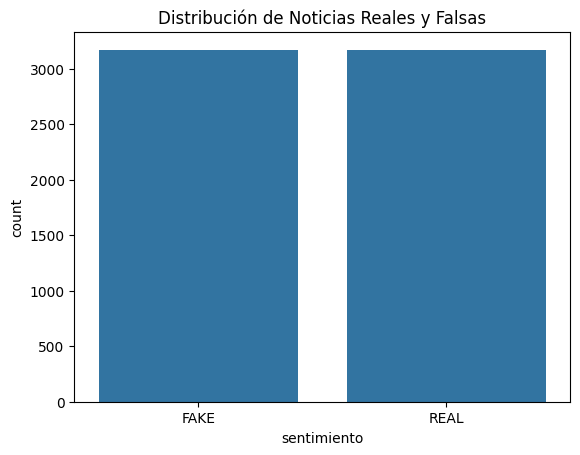

In [68]:
sns.countplot(x=df['sentimiento'])
plt.title("Distribución de Noticias Reales y Falsas")
plt.show()



* Se puede observar que el dataset está bastante balanceado. Ya que se contabilizan 3171 noticias reales y 3164 noticias fake.

    En caso que no lo estuviese se podria:
* Submuestrear (undersampling), reduciendo el número de muestras de la clase mayoritaria.
* Sobremuestrear (oversampling), aumentando el número de muestras de la clase minoritaria duplicando datos o generando datos sintéticos con técnicas como SMOTE.


#Diferencias entre variables en ML tradicional vs NLP

1. Tipo de variables:
* ML tradicional: Numéricas y categóricas.
* NLP: Texto, que debe convertirse en números.

2. Preprocesamiento:
* ML tradicional: Normalmente solo escalamos valores numéricos o codificamos variables categóricas.
* NLP: Tokenización, lematización/stemming, eliminar stopwords, convertir a vectores.

3. Estructura de datos:
* ML tradicional: Datos tabulares (filas y columnas).
* NLP: Texto sin estructura fija → Secuencias de palabras o embeddings.

4. Balance de clases:
* ML tradicional: Sobremuestreo/Submuestreo.
* NLP: Además, técnicas como data augmentation (sinonimización, traducción automática).

In [69]:
# Corta a un nùmero reducido de noticias para facilitar el procesamiento


n_samples = 1000

# Seleccionar n_samples de cada clase
df_real = df[df['sentimiento'] == 'REAL'].sample(n=n_samples, random_state=42)
df_fake = df[df['sentimiento'] == 'FAKE'].sample(n=n_samples, random_state=42)

# Unir ambos subconjuntos
df_balanced = pd.concat([df_real, df_fake]).sample(frac=1, random_state=42)  # Mezclar aleatoriamente

In [70]:
# Las clases quedaron balanceadas?
df_balanced['sentimiento'].value_counts()

,count
sentimiento,
FAKE,1000
REAL,1000


In [71]:
df_balanced.head()

,title,texto,sentimiento
Unnamed: 0,,,
10541,Germany: Children in one school required to ch...,"Print \n[Ed. – Coming soon to a — oh, wait. It...",FAKE
3829,"Sure, We Want An Honest And Trustworthy Presid...","Sure, We Want An Honest And Trustworthy Presid...",REAL
6226,PENNSYLVANIA GUN STORE tells customers “Muslim...,PENNSYLVANIA GUN STORE tells customers “Muslim...,FAKE
4770,Donald Trump can’t resist blaming Bill Clinton...,"Even by his standards, Donald Trump's reaction...",REAL
8195,The US Elections Do Matter But Not Necessary T...,"By Rixon Stewart on September 12, 2006 \nIs te...",FAKE


In [72]:
# Ajustar etiquetas de sentimiento (0 = fake, 1 = real)
df_balanced['sentimiento'] = df_balanced['sentimiento'].map({'FAKE': 0, 'REAL': 1})
df_balanced['sentimiento'].value_counts()


,count
sentimiento,
0,1000
1,1000


#Preprocesamiento: Tokenización, lematización, eliminación de stopwords y caracteres especiales.

In [73]:
def preprocesar_texto(texto):
    """Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales."""
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
    return " ".join(tokens)

In [74]:
# Aplicar preprocesamiento
def preprocess_text(texto):
  texto = texto.lower()
  texto = re.sub(r'[^a-zA-Z\s]', '', texto)
  tokens = word_tokenize(texto)
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return ' '.join(tokens)



In [83]:
df_balanced['clean_text'] = df_balanced['texto'].apply(preprocess_text)
df_balanced.head()

,title,texto,sentimiento,clean_text
Unnamed: 0,,,,
10541,Germany: Children in one school required to ch...,"Print \n[Ed. – Coming soon to a — oh, wait. It...",0,print ed coming soon oh wait already pupil pri...
3829,"Sure, We Want An Honest And Trustworthy Presid...","Sure, We Want An Honest And Trustworthy Presid...",1,sure want honest trustworthy president complic...
6226,PENNSYLVANIA GUN STORE tells customers “Muslim...,PENNSYLVANIA GUN STORE tells customers “Muslim...,0,pennsylvania gun store tell customer muslim hi...
4770,Donald Trump can’t resist blaming Bill Clinton...,"Even by his standards, Donald Trump's reaction...",1,even standard donald trump reaction release au...
8195,The US Elections Do Matter But Not Necessary T...,"By Rixon Stewart on September 12, 2006 \nIs te...",0,rixon stewart september television entertainme...


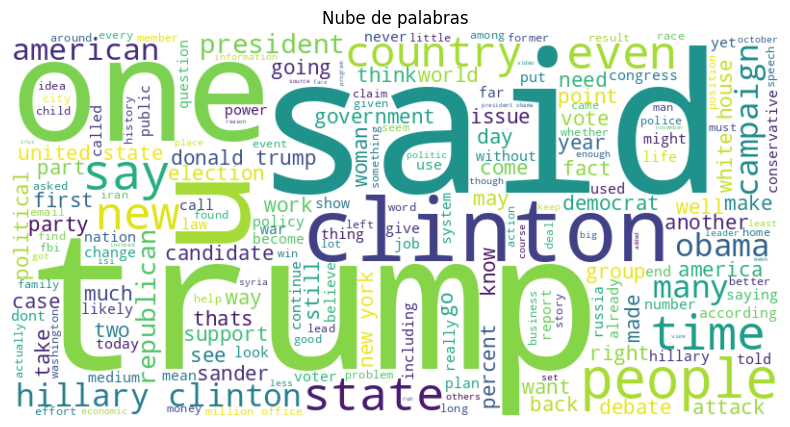

In [85]:
# Visualizar nube de palabras completando la secuencia de creaciòn
text_combined = " ".join(df_balanced['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras")
plt.show()

Unigramas más comunes:
       N-gram  Frecuencia
0       trump        7108
1        said        6472
2     clinton        5726
3       state        4624
4       would        3921
5         one        3650
6      people        3588
7         new        2899
8   president        2826
9  republican        2791


<ipython-input-86-093a888cbcf0>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


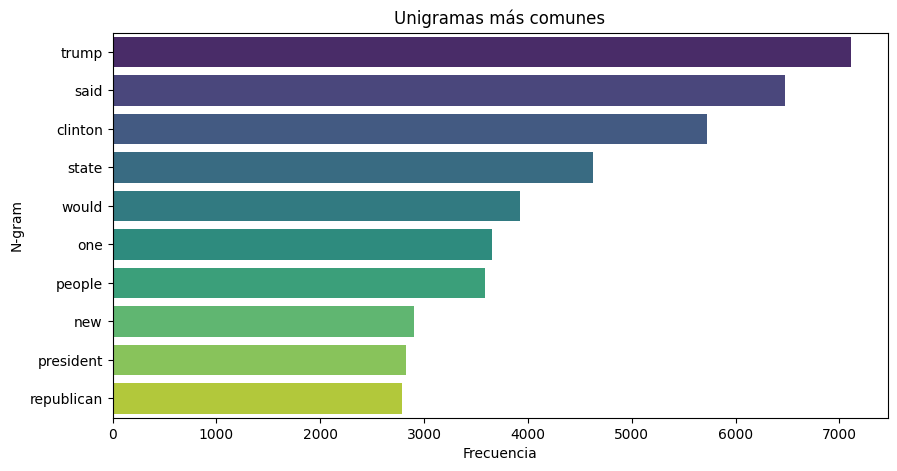

Bigramas más comunes:
            N-gram  Frecuencia
0  hillary clinton        1336
1     donald trump        1205
2     united state         886
3      white house         783
4         new york         732
5  secretary state         381
6  president obama         332
7   foreign policy         330
8    islamic state         316
9       trump said         310


<ipython-input-86-093a888cbcf0>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


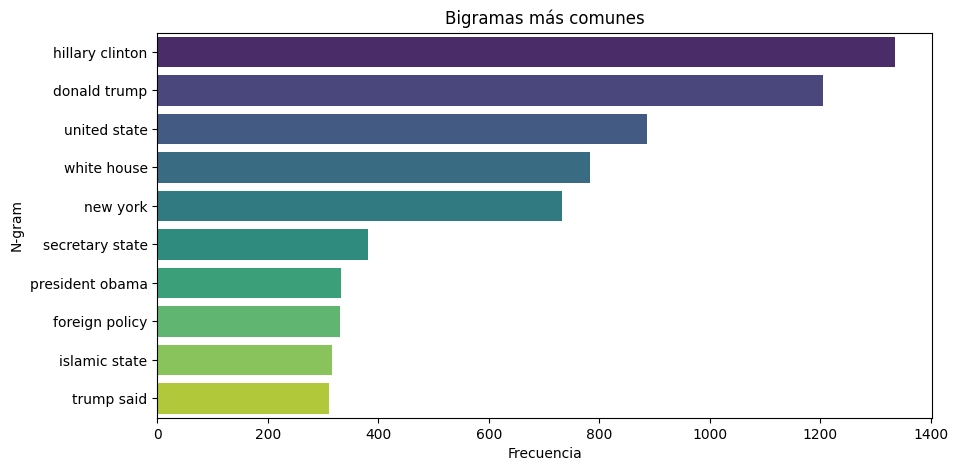

Trigramas más comunes:
                              N-gram  Frecuencia
0                      new york time         216
1             president barack obama          96
2             president united state          91
3             former secretary state          78
4                       sen ted cruz          78
5                 fbi director james          72
6  republican presidential candidate          70
7                      new york city          68
8                  sen bernie sander          67
9                wall street journal          64


<ipython-input-86-093a888cbcf0>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


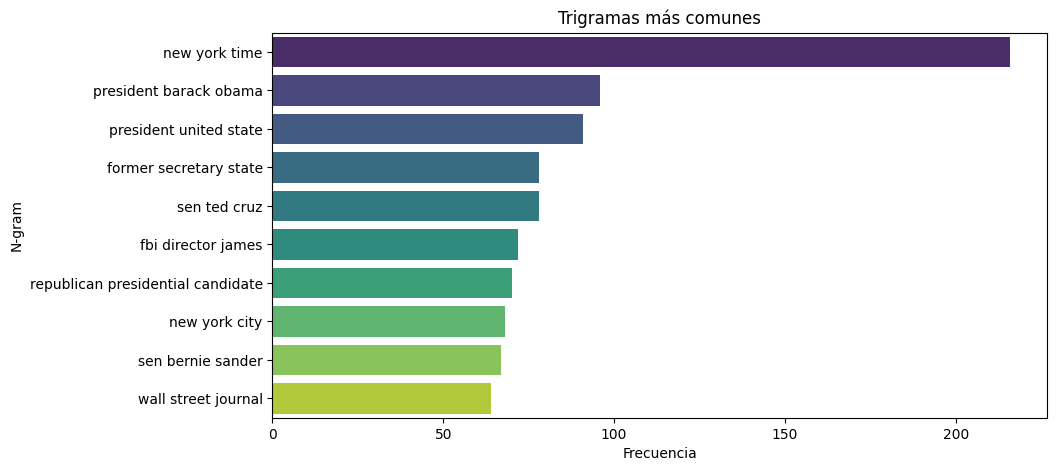

Cuatrigramas más comunes:
                                N-gram  Frecuencia
0             fbi director james comey          60
1  associated press contributed report          47
2      majority leader mitch mcconnell          43
3                 ohio gov john kasich          43
4         senate majority leader mitch          38
5           secretary state john kerry          36
6             vice president joe biden          30
7       attorney general loretta lynch          29
8         donald trump hillary clinton          29
9           house speaker john boehner          29


<ipython-input-86-093a888cbcf0>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


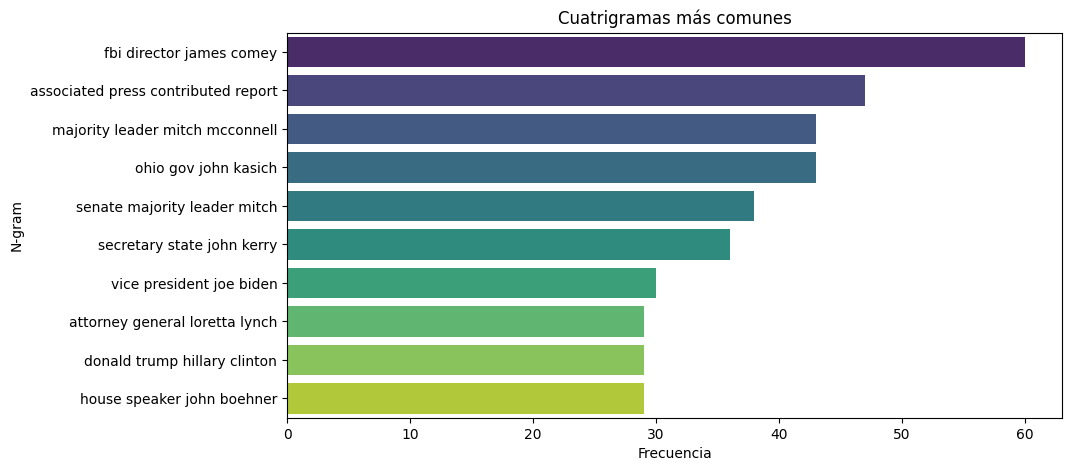

In [86]:
# Análisis de n-grams, adicionar bigramas, trigramas y cuatrigramas. Plotearlos.
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_features, ngram_counts))
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-gram")
    plt.show()

unigrams = get_top_ngrams(df_balanced['clean_text'], 1)
bigrams = get_top_ngrams(df_balanced['clean_text'], 2)
trigrams = get_top_ngrams(df_balanced['clean_text'], 3)
fourgrams = get_top_ngrams(df_balanced['clean_text'], 4)

print("Unigramas más comunes:")
print(unigrams)
plot_ngrams(unigrams, "Unigramas más comunes")

print("Bigramas más comunes:")
print(bigrams)
plot_ngrams(bigrams, "Bigramas más comunes")

print("Trigramas más comunes:")
print(trigrams)
plot_ngrams(trigrams, "Trigramas más comunes")

print("Cuatrigramas más comunes:")
print(fourgrams)
plot_ngrams(fourgrams, "Cuatrigramas más comunes")

In [87]:
# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['clean_text'],
    df_balanced['sentimiento'],
    test_size=0.2,  # Porcentaje de datos para prueba (20%)
    random_state=42
)

In [88]:
# Pipeline de vectorización y modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [90]:
# Entrenar modelo
pipeline.fit(X_train, y_train)

# Predicciones
y_pred = pipeline.predict(X_test)

In [91]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.725
              precision    recall  f1-score   support

           0       0.98      0.47      0.63       203
           1       0.64      0.99      0.78       197

    accuracy                           0.72       400
   macro avg       0.81      0.73      0.71       400
weighted avg       0.81      0.72      0.71       400



In [92]:
##DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)
## DataFlair - fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [94]:
from sklearn.linear_model import PassiveAggressiveClassifier
PassiveAggressiveClassifier

sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier

In [95]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [96]:
y_pred2=pac.predict(tfidf_test)

In [97]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.8975
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       203
           1       0.90      0.89      0.90       197

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400

